In [27]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEMhd
from importlib import reload  
KSEMhd = reload(KSEMhd)
from KSEMhd import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_montreal"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (156018.171662324 > 2 * 27305.177399710472). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (156018.171662324 > 2 * 27305.177399710472). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.992, 0.008], [0.020000000000000018, 0.98]],
 'gate_qubits': [(26,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-09-29 07:30:20-04:00


In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

# plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True, meas_x = False):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if meas_x:
        for i in range(n_qubits):
            total_circ.h(i)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

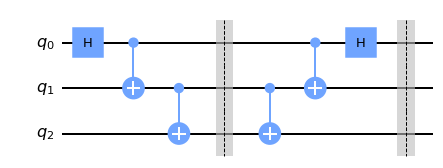

In [8]:
single_iter(n_qubits).draw("mpl")

10


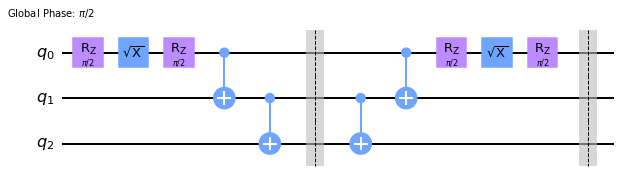

In [9]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [10]:
# temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
# temp_circ3 = transpile(temp_circ2, backend=backend)
# print("Depth:", temp_circ3.depth())
# print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
# print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
# dt = backend.configuration().dt # sec
# temp_sch = schedule(temp_circ3, backend)
# print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [11]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [12]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'111': 201,
 '011': 606,
 '000': 56667,
 '010': 1986,
 '100': 1559,
 '110': 244,
 '001': 3970,
 '101': 303}

In [13]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(KSEMhd.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9387248345997158
0.8832423047668297
0.8329904349331702
0.7874630399904101
0.7462041135504048
0.7088027847901779
0.674888786042873
0.6441283791922279
0.6162206942225884
0.5908944380306259

Prob Vec
[0.92059326 0.02476501 0.02493286 0.00357056 0.02180481 0.00157166
 0.00161743 0.00114441]
[0.8910675  0.0428772  0.02867126 0.00592041 0.02365112 0.00315857
 0.00242615 0.00222778]
[0.86489868 0.06118774 0.02992249 0.00971985 0.02336121 0.00419617
 0.0037384  0.00297546]
[0.84011841 0.07603455 0.03175354 0.01249695 0.0247345  0.00611877
 0.0045166  0.00422668]
[0.81660461 0.09185791 0.0335083  0.01564026 0.02459717 0.00660706
 0.00588989 0.0052948 ]
[0.79318237 0.10803223 0.03569031 0.01707458 0.02435303 0.00907898
 0.00686646 0.00572205]
[0.77067566 0.12185669 0.03671265 0.02113342 0.02563477 0.01016235
 0.00717163 0.00665283]
[0.75028992 0.13470459 0.04029846 0.02297974 0.02531433 0.01071167
 0.008255   0.00744629]
[0.72918701 0.1481781  0.04121399 0.02601624 0.026474   0.01173401

In [14]:
def meas_mat(num_qubits):# H, measurement matrix for vectorized density matrix
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = csc_matrix((nrows, ncols), dtype=complex)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1 # take out the diagonal terms in vectorized density matrix
    return mat

## State Tomography

### Use a Noise Model without Measurement Error for Tomography

In [15]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (156018.171662324 > 2 * 27305.177399710472). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (156018.171662324 > 2 * 27305.177399710472). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 

In [16]:
np.random.seed(7)

tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=den_simu_for_tomo)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=np.random.randint(10**8)).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.8363001560091098
0.7974833095982583
0.755336936672531
0.7071572530386183
0.6860850697893363
0.653358607129645
0.6108775533018599
0.6076796368778349
0.5661945413524507
0.5534654193454321

Tomography Prob Vec
[0.90752268 0.02515714 0.0252223  0.00587538 0.01986892 0.00625149
 0.00524652 0.00485556]
[0.88672607 0.04106026 0.02741584 0.00557775 0.02330155 0.00763455
 0.00501422 0.00326975]
[0.86035867 0.05713711 0.03188851 0.0113001  0.02095035 0.00927576
 0.00609686 0.00299264]
[0.83103831 0.07493525 0.04009704 0.01114107 0.02696468 0.00632302
 0.00491752 0.00458313]
[0.8161974  0.08368614 0.02948156 0.0228297  0.02464183 0.00822149
 0.00934132 0.00560057]
[0.79363878 0.10466813 0.03412167 0.01828105 0.02120894 0.00974589
 0.01088681 0.00744872]
[0.76260041 0.12169022 0.037065   0.0199719  0.0343948  0.00912416
 0.00526395 0.00988956]
[0.75929422 0.12941614 0.03592104 0.0202115  0.02540094 0.01035683
 0.00739926 0.01200008]
[0.72813262 0.14026028 0.04015827 0.02928729 

## Kalman Smoother

In [17]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

## Add X-basis measurements

In [18]:
total_simu_probs_x = [] # measurement result, x-basis
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False, meas_x = True), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    total_simu_probs_x.append(KSEMhd.dictToVec(iter_res.get_counts()))

In [19]:
total_simu_probs_x

[array([0.13873291, 0.13380432, 0.11593628, 0.11074829, 0.13949585,
        0.13508606, 0.11376953, 0.11242676]),
 array([0.14152527, 0.13388062, 0.11668396, 0.11004639, 0.1391449 ,
        0.1342926 , 0.11494446, 0.10948181]),
 array([0.13967896, 0.13330078, 0.11689758, 0.11006165, 0.14091492,
        0.1335144 , 0.11721802, 0.1084137 ]),
 array([0.14335632, 0.13076782, 0.11813354, 0.10810852, 0.13978577,
        0.13374329, 0.11578369, 0.11032104]),
 array([0.14358521, 0.12965393, 0.11790466, 0.10768127, 0.14257812,
        0.13320923, 0.11639404, 0.10899353]),
 array([0.14256287, 0.13153076, 0.11854553, 0.10871887, 0.14230347,
        0.13026428, 0.1161499 , 0.10992432]),
 array([0.14485168, 0.1312561 , 0.11843872, 0.10960388, 0.14309692,
        0.12928772, 0.11961365, 0.10385132]),
 array([0.14546204, 0.12867737, 0.11976624, 0.10673523, 0.14413452,
        0.1295929 , 0.11947632, 0.1061554 ]),
 array([0.14543152, 0.13064575, 0.11882019, 0.10710144, 0.14431763,
        0.12942505, 

In [20]:
observs = []
for i in range(len(total_simu_probs)):
    z_meas_p = total_simu_probs[i]
    x_meas_p = total_simu_probs_x[i]
    observs.append(np.append(z_meas_p, x_meas_p))
observs

[array([0.92059326, 0.02476501, 0.02493286, 0.00357056, 0.02180481,
        0.00157166, 0.00161743, 0.00114441, 0.13873291, 0.13380432,
        0.11593628, 0.11074829, 0.13949585, 0.13508606, 0.11376953,
        0.11242676]),
 array([0.8910675 , 0.0428772 , 0.02867126, 0.00592041, 0.02365112,
        0.00315857, 0.00242615, 0.00222778, 0.14152527, 0.13388062,
        0.11668396, 0.11004639, 0.1391449 , 0.1342926 , 0.11494446,
        0.10948181]),
 array([0.86489868, 0.06118774, 0.02992249, 0.00971985, 0.02336121,
        0.00419617, 0.0037384 , 0.00297546, 0.13967896, 0.13330078,
        0.11689758, 0.11006165, 0.14091492, 0.1335144 , 0.11721802,
        0.1084137 ]),
 array([0.84011841, 0.07603455, 0.03175354, 0.01249695, 0.0247345 ,
        0.00611877, 0.0045166 , 0.00422668, 0.14335632, 0.13076782,
        0.11813354, 0.10810852, 0.13978577, 0.13374329, 0.11578369,
        0.11032104]),
 array([0.81660461, 0.09185791, 0.0335083 , 0.01564026, 0.02459717,
        0.00660706, 0.005889

### Initialize

In [21]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [22]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = observs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [23]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 16, 4096)

### EM and Smoother - Total

Use longest iterations

In [28]:
total_smoother_dens = []
total_smoother_purs = []

# observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
    x_est = (x_est+x_est.H)/2
    final_den = KSEMhd.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

Iteration statrts New ll 2501.62-0.00j, Last ll 1250.81-0.00j
Iteration     1, New log-likelihood 2.24991e+23-2.61834e+20j, Last log-likelihood 2.50162e+03-1.49144e-31j, Change 2.24991e+23-2.61834e+20j
Iteration     2, New log-likelihood 1.06261e+12+7.14372e+10j, Last log-likelihood 2.24991e+23-2.61834e+20j, Change -2.24991e+23+2.61834e+20j
Iteration     3, New log-likelihood 2.73551e+08-1.05590e+08j, Last log-likelihood 1.06261e+12+7.14372e+10j, Change -1.06234e+12-7.15428e+10j
Iteration     4, New log-likelihood 2.48100e+09+7.60962e+09j, Last log-likelihood 2.73551e+08-1.05590e+08j, Change 2.20745e+09+7.71521e+09j
Iteration     5, New log-likelihood -1.10489e+15-6.89504e+15j, Last log-likelihood 2.48100e+09+7.60962e+09j, Change -1.10490e+15-6.89505e+15j


KeyboardInterrupt: 

In [ ]:
plt.imshow(realF.real)
plt.colorbar()
plt.show()

In [ ]:
np.linalg.norm(realQ.imag), np.linalg.norm(realR.imag)

In [ ]:
plt.imshow(realQ.real)
plt.colorbar()
plt.show()

Only use the estimation in the final iteration as the valid output

In [ ]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     print("Circuit Iteration", i)
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [ ]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

In [ ]:
total_smoother_dens[0].diagonal().flatten()

In [ ]:
np.diag(np.array(total_smoother_dens[0].diagonal()).flatten())

In [ ]:
with np.printoptions(precision=3, suppress=True):
    for den in total_smoother_dens:
        non_diag_den = den - np.diag(np.array(den.diagonal()).flatten())
        print(np.linalg.norm(non_diag_den))
#     print(total_smoother_dens[8])
#     print(total_simu_dens[8].data)

In [ ]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

## Check the fidelity between estimated state and the real state in the simulator

In [ ]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

In [ ]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

In [ ]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

In [ ]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()

In [ ]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur.svg")
plt.show()

In [ ]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()